In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config_BreastMNIST import *


## Reproducibility

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_52395/2636605336.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


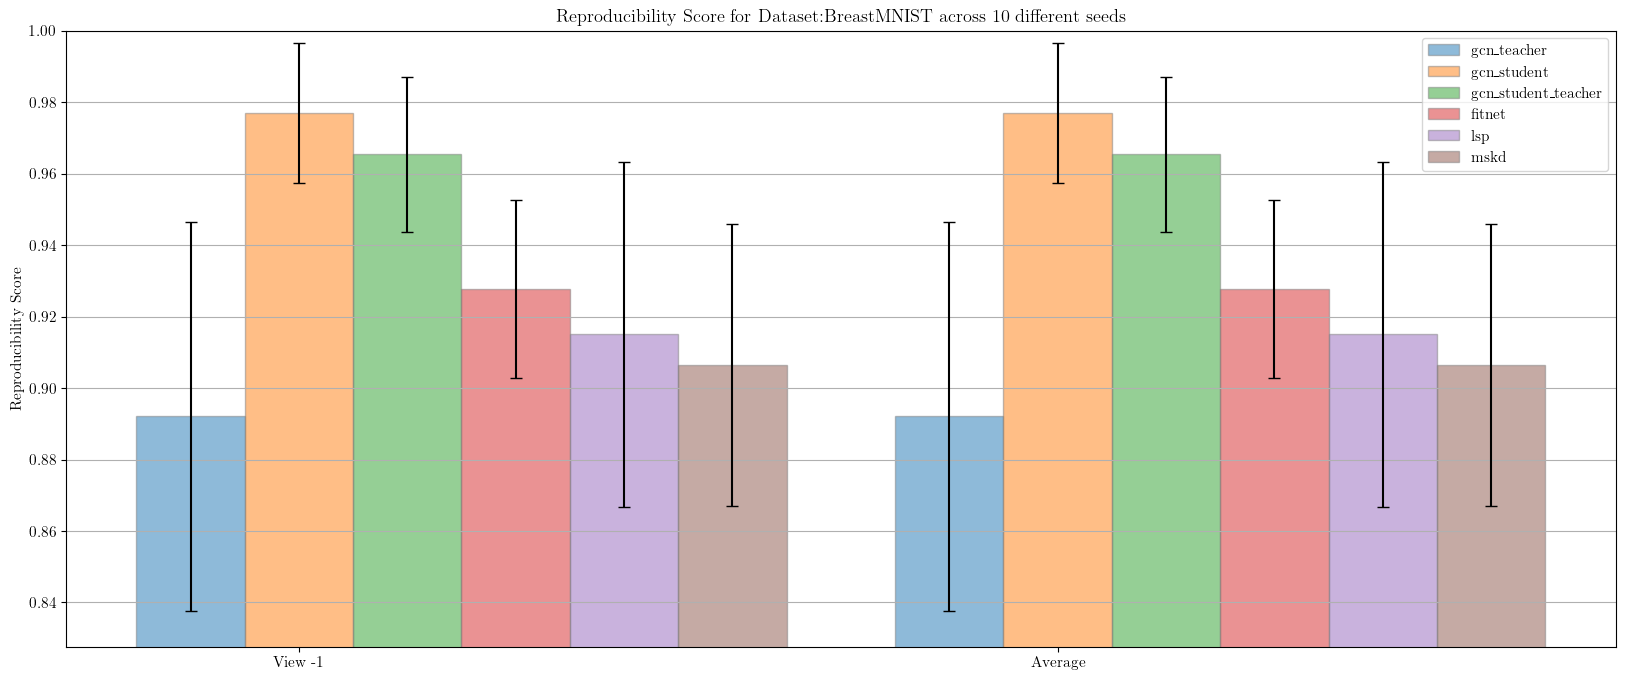

<Figure size 2000x800 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="BreastMNIST"
views=[-1]
models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
model_args = [
    gcn_BreastMNIST_args, 
    gcn_student_BreastMNIST_args, 
    gcn_student_BreastMNIST_args, 
    gcn_fitnet_student_BreastMNIST_args,
    gcn_lsp_student_BreastMNIST_args,
    gcn_mskd_student_BreastMNIST_args
]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

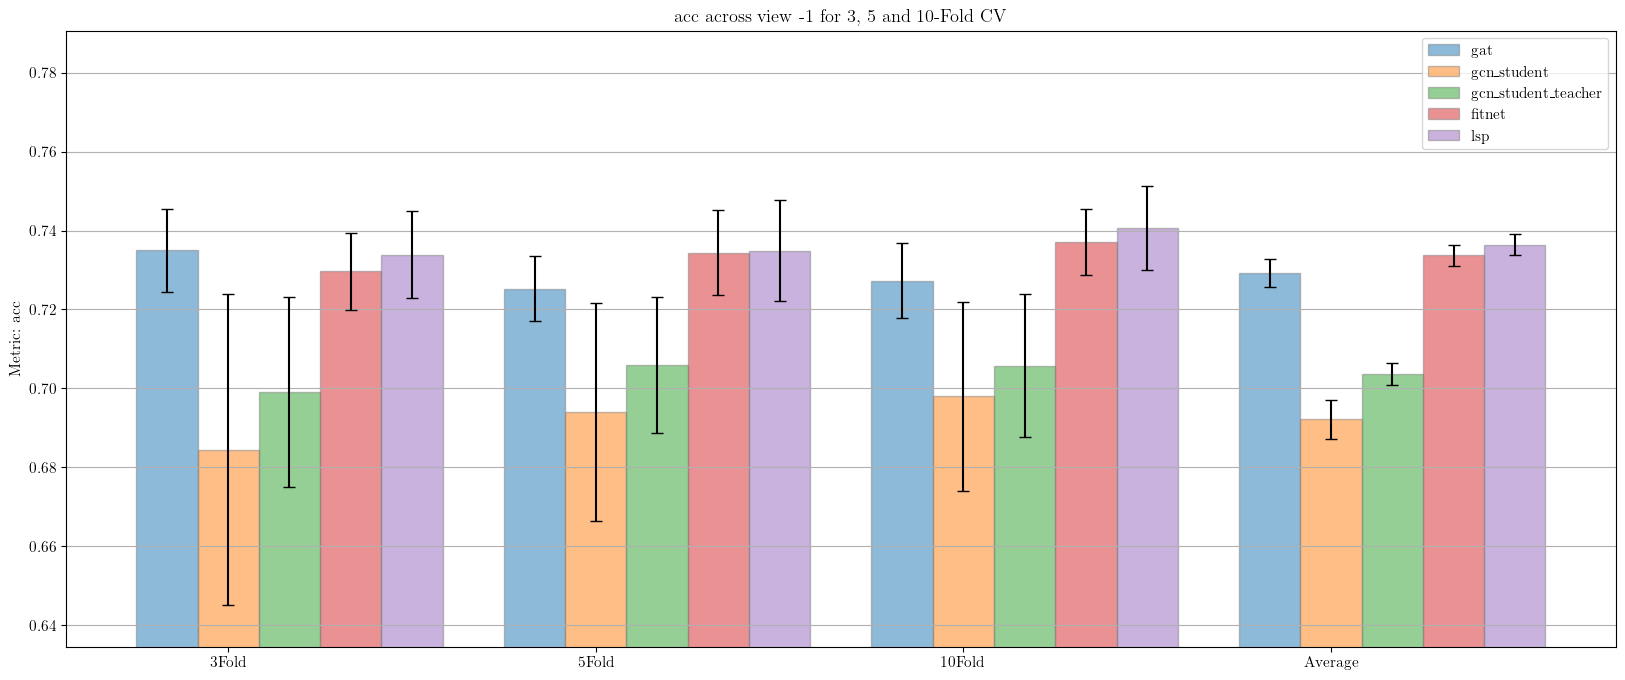

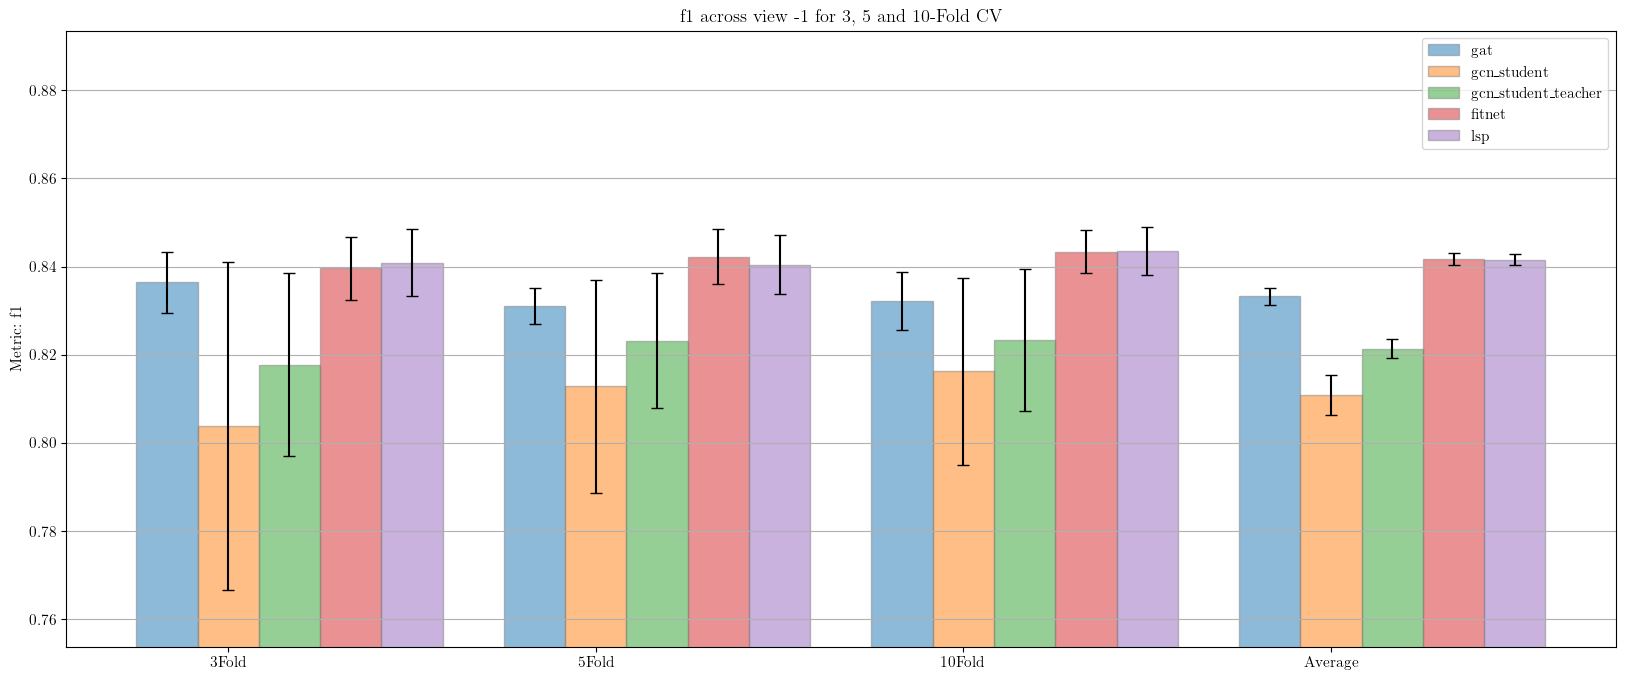

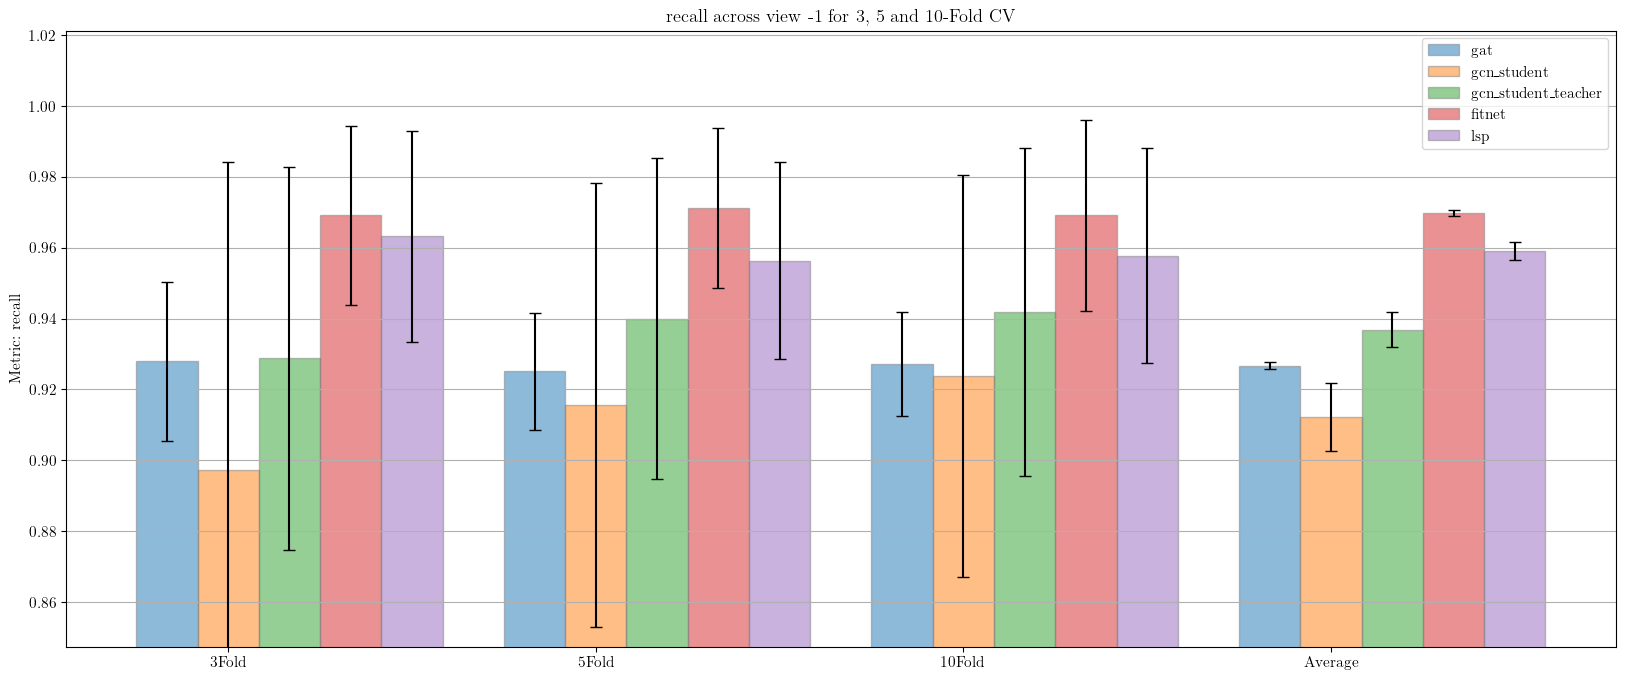

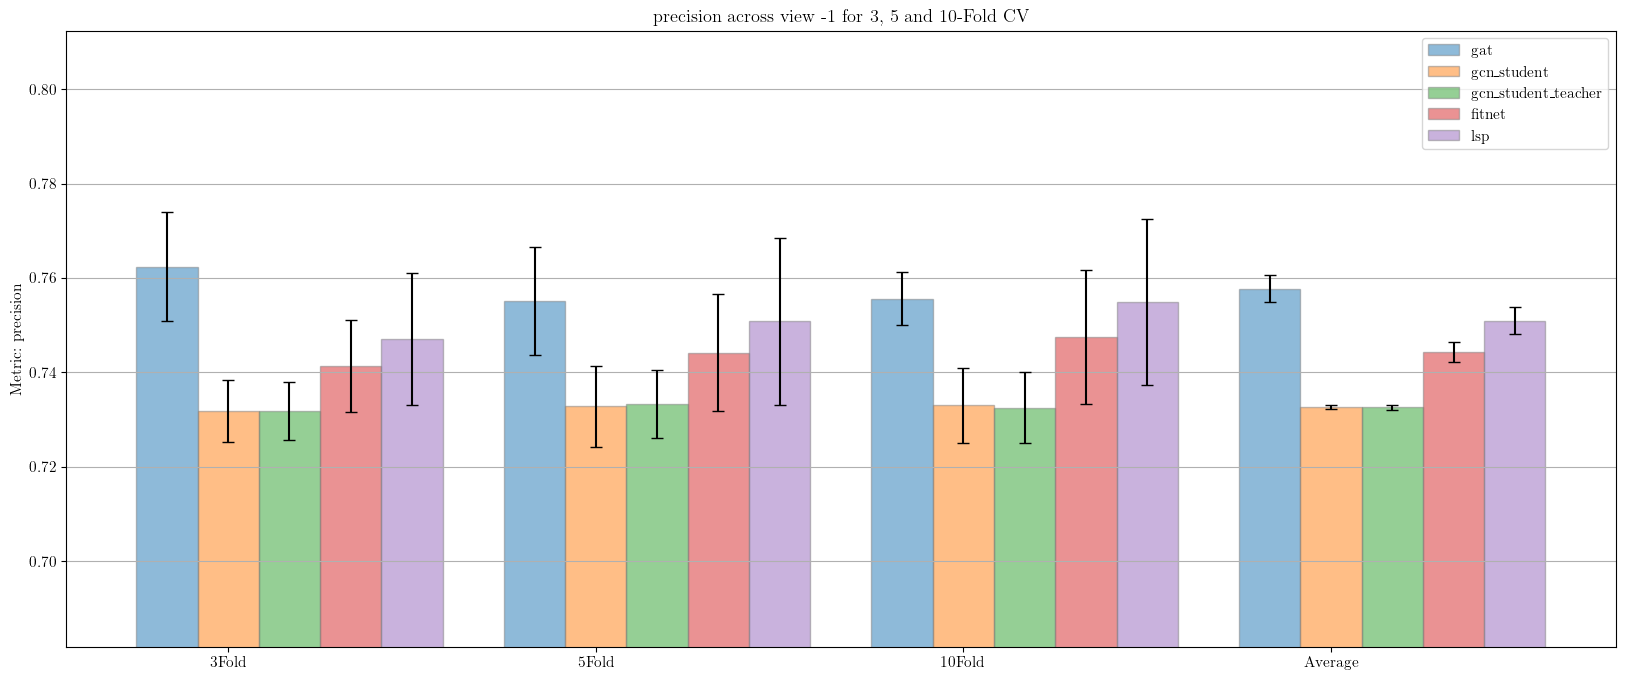

<Figure size 2000x800 with 0 Axes>

In [7]:
for view in [-1]:
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="f1", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)


# ENSAMBLE ANALYSIS

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from models.model_config import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [11]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [12]:
def get_best_student_ensamble(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

In [13]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [10]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "BreastMNIST"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_2_BreastMNIST_args,
    gcn_student_lsp_ensamble_3_BreastMNIST_args,
    gcn_student_lsp_ensamble_4_BreastMNIST_args,
    gcn_student_lsp_ensamble_5_BreastMNIST_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    mean, var, best_students = get_best_student_ensamble_detailed(
        model=model_arg["model_name"], 
        view=-1, 
        CV=CV,
        dataset=dataset,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=model_arg
    )
    print(best_students)
    all_model_metrics_mean.append(mean)
    all_model_metrics_var.append(var)
    all_model_best_student.append(best_students)


gcn_student_lsp_ensamble_2
[[0.9445833333333334, 0.0003821180555555545, 1], [0.9445833333333334, 0.0003821180555555545, 1], [0.9445833333333334, 0.0003821180555555545, 1], [0.9445833333333334, 0.0003821180555555545, 1], [0.9445833333333334, 0.0003821180555555545, 1]]
gcn_student_lsp_ensamble_3
[[0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1]]
gcn_student_lsp_ensamble_4
[[0.9541666666666666, 0.001069058641975308, 0], [0.9313888888888888, 0.0004128858024691338, 3], [0.9313888888888888, 0.0004128858024691338, 3], [0.9313888888888888, 0.0004128858024691338, 3], [0.9491666666666667, 0.00042330246913580396, 2]]
gcn_student_lsp_ensamble_5
[[0.9445833333333333, 0.0008747878086419745, 0], [0.9327777777777777, 0.0005614197530864196, 3], [0.9327777777777777, 0.0005614197530864196, 3], [0.9327777777777777, 0.0005614197530864196, 3], [0.9327777777777777, 0.00056141

In [12]:
df_best_student = np.array(all_model_best_student)
df_metrics_var = np.array(all_model_metrics_var)
df_model_mean = np.array(all_model_metrics_mean)

In [13]:
df_model_mean[0][1]

array([0.73051282, 0.83066292, 0.90672515, 0.7679701 ])

In [14]:
df_model_mean[1][1]

array([0.72683761, 0.82444061, 0.88181287, 0.7769416 ])

In [15]:
df_model_mean[2][3]

array([0.73495726, 0.83978865, 0.95134503, 0.75250211])

In [17]:
df_model_mean[1][1], df_metrics_var[1][1], df_best_student[1]

(array([0.72683761, 0.82444061, 0.88181287, 0.7769416 ]),
 array([1.18270144e-05, 1.76271050e-05, 2.18217571e-04, 3.18372792e-05]),
 array([[9.67500000e-01, 2.09953704e-04, 1.00000000e+00],
        [9.67500000e-01, 2.09953704e-04, 1.00000000e+00],
        [9.67500000e-01, 2.09953704e-04, 1.00000000e+00],
        [9.67500000e-01, 2.09953704e-04, 1.00000000e+00],
        [9.67500000e-01, 2.09953704e-04, 1.00000000e+00]]))

In [60]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [61]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [62]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [22]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="BreastMNIST", 
    views=[-1], 
    models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd", "gcn_student_lsp_ensamble_3"],
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [1]
    ], 
    model_args = [
        gcn_BreastMNIST_args, 
        gcn_student_BreastMNIST_args, 
        gcn_student_BreastMNIST_args, 
        gcn_fitnet_student_BreastMNIST_args,
        gcn_lsp_student_BreastMNIST_args,
        gcn_mskd_student_BreastMNIST_args,
        gcn_student_lsp_ensamble_3_BreastMNIST_args
    ])

In [23]:
mean_all_runs, mean_all_std

(array([[0.89208333, 0.89208333],
        [0.97694444, 0.97694444],
        [0.96541667, 0.96541667],
        [0.92763889, 0.92763889],
        [0.915     , 0.915     ],
        [0.90638889, 0.90638889],
        [0.9675    , 0.9675    ]]),
 array([[0.05448641, 0.05448641],
        [0.0196045 , 0.0196045 ],
        [0.02169914, 0.02169914],
        [0.02486421, 0.02486421],
        [0.04820785, 0.04820785],
        [0.0394855 , 0.0394855 ],
        [0.01448978, 0.01448978]]))

In [27]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd", "gcn_student_lsp_ensamble_3"]
reproducibility_frame.columns = models

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_lsp_ensamble_3"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_lsp_ensamble_3"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

In [28]:
reproducibility_frame

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_lsp_ensamble_3,delta teacher,delta student
0,0.892083,0.976944,0.965417,0.927639,0.915,0.906389,0.9675,8.453993,-0.966733
1,0.892083,0.976944,0.965417,0.927639,0.915,0.906389,0.9675,8.453993,-0.966733


In [30]:
average_across_views_df_std = pd.DataFrame(view_std[0][:,-1])
average_across_views_df_std.T

,0,1,2,3,4,5,6
0,0.003096,0.006559,0.006041,0.000774,0.001709,0.000353,0.001288


In [32]:
models=["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd", "gcn_student_lsp_ensamble_3"]

average_across_views_df = pd.DataFrame(view_mean[0][:,-1])
average_across_views_df_mean = average_across_views_df.T

average_across_views_df_mean.columns = models
average_across_views_df_mean

average_across_views_df_mean["delta teacher"] = ((average_across_views_df_mean["gcn_student_lsp_ensamble_3"] - average_across_views_df_mean["gcn"]) / average_across_views_df_mean["gcn"])*100
average_across_views_df_mean["delta student"] = ((average_across_views_df_mean["gcn_student_lsp_ensamble_3"] - average_across_views_df_mean["gcn_student"]) / average_across_views_df_mean["gcn_student"])*100

average_across_views_df_mean

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_lsp_ensamble_3,delta teacher,delta student
0,0.724829,0.692137,0.703376,0.733205,0.734103,0.739872,0.726838,0.277106,5.013584


# LSP vs Logits

In [14]:
from models.model_config import *

analysis_type="model_assessment"
dataset = "BreastMNIST"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_BreastMNIST_args,
    gcn_student_ensamble_3_BreastMNIST_args,
    gcn_student_ensamble_4_BreastMNIST_args,
    gcn_student_ensamble_5_BreastMNIST_args,
    gcn_student_lsp_ensamble_2_BreastMNIST_args,
    gcn_student_lsp_ensamble_3_BreastMNIST_args,
    gcn_student_lsp_ensamble_4_BreastMNIST_args,
    gcn_student_lsp_ensamble_5_BreastMNIST_args
]

all_model_data_mean = []
all_model_data_std = []

for model_arg in models_args:
    
    model_data_mean = []
    model_data_std = []
    
    print(model_arg["model_name"])
    
    for view in [-1]:
        
        rep = get_best_student_ensamble(
            model=model_arg["model_name"], 
            dataset=dataset,
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )[1]
        model_data_mean.append(rep[0])
        model_data_std.append(rep[1])
    
    all_model_data_mean.append(model_data_mean)
    all_model_data_std.append(model_data_std)

gcn_student_ensamble_2
gcn_student_ensamble_3
gcn_student_ensamble_4
gcn_student_ensamble_5
gcn_student_lsp_ensamble_2
gcn_student_lsp_ensamble_3
gcn_student_lsp_ensamble_4
gcn_student_lsp_ensamble_5


In [15]:
df = pd.DataFrame(all_model_data_mean)

df_transposed = df.T
# Calculate the mean along each column
mean_row = df_transposed.mean()

# Add the mean row to the transposed DataFrame
df_transposed = df_transposed.append(mean_row, ignore_index=True)
print(df_transposed.head())

          0         1         2     3         4       5         6         7
0  0.957778  0.961389  0.929167  0.94  0.944583  0.9675  0.931389  0.932778
1  0.957778  0.961389  0.929167  0.94  0.944583  0.9675  0.931389  0.932778


In [16]:
df = pd.DataFrame(np.sqrt(all_model_data_std))

df_transposed_var = df.T
# Calculate the mean along each column
std_row = df_transposed.std()

# Add the mean row to the transposed DataFrame
df_std_transposed = df_transposed_var.append(std_row, ignore_index=True)
df_std_transposed

,0,1,2,3,4,5,6,7
0,0.020443,0.01773,0.024383,0.03108,0.019548,0.01449,0.02032,0.023694
1,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000


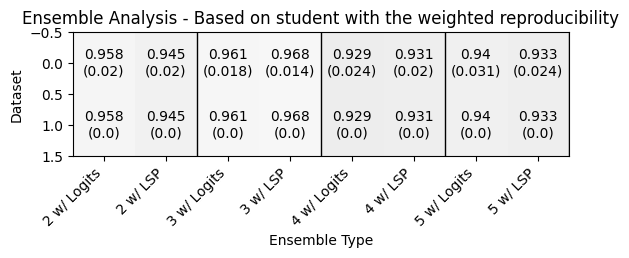

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_transposed.iloc[:, column_order]
df_std_ordered = df_std_transposed.iloc[:, column_order]

# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df.shape[0], 2):
    pair_max = max(df.iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Based on student with the weighted reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')
if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Based on student with the average reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()


In [21]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_BreastMNIST_args,
    gcn_student_ensamble_3_BreastMNIST_args,
    gcn_student_ensamble_4_BreastMNIST_args,
    gcn_student_ensamble_5_BreastMNIST_args,
    gcn_student_lsp_ensamble_2_BreastMNIST_args,
    gcn_student_lsp_ensamble_3_BreastMNIST_args,
    gcn_student_lsp_ensamble_4_BreastMNIST_args,
    gcn_student_lsp_ensamble_5_BreastMNIST_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [-1]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg,
            dataset=dataset
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_ensamble_2
[[0.957777777777778, 0.0004179012345679009, 1], [0.957777777777778, 0.0004179012345679009, 1], [0.957777777777778, 0.0004179012345679009, 1], [0.957777777777778, 0.0004179012345679009, 1], [0.957777777777778, 0.0004179012345679009, 1]]
gcn_student_ensamble_3
[[0.9613888888888891, 0.00031435185185185374, 1], [0.9613888888888891, 0.00031435185185185374, 1], [0.9613888888888891, 0.00031435185185185374, 1], [0.9613888888888891, 0.00031435185185185374, 1], [0.9613888888888891, 0.00031435185185185374, 1]]
gcn_student_ensamble_4
[[0.9479166666666667, 0.001057966820987654, 0], [0.9291666666666668, 0.0005945216049382705, 3], [0.9291666666666668, 0.0005945216049382705, 3], [0.9291666666666668, 0.0005945216049382705, 3], [0.9291666666666668, 0.0005945216049382705, 3]]
gcn_student_ensamble_5
[[0.9415277777777777, 0.00144577546296296, 2], [0.9400000000000001, 0.000965972222222224, 3], [0.9400000000000001, 0.000965972222222224, 3], [0.9400000000000001, 0.000965972222222224, 3]

In [23]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(1):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(40, 2)

In [25]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(1):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [26]:
all_data_var = []
for view_index in range(1):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [27]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(40, 2)

In [28]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(40, 2)

In [29]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

In [30]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
new_labels = ['2 w/ Logits', '3 w/ Logits', '4 w/ Logits','5 w/ Logits', '2 w/ LSP', '3 w/ LSP', '4 w/ LSP',  '5 w/ LSP']
# Rename the columns using the new labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
# Display the modified DataFrame
df_var

,2 w/ Logits,3 w/ Logits,4 w/ Logits,5 w/ Logits,2 w/ LSP,3 w/ LSP,4 w/ LSP,5 w/ LSP
0,0.003621,0.003195,0.003315,0.004025,0.003124,0.003439,0.00296,0.003642
1,0.003621,0.003195,0.003315,0.004025,0.003124,0.003439,0.00296,0.003642


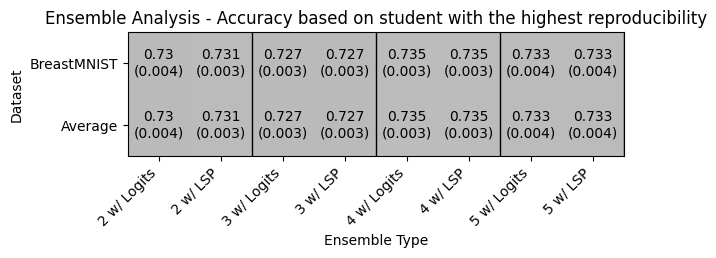

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_acuracy.iloc[:, column_order]
df_std_ordered = df_var.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['BreastMNIST', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Accuracy based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Accuracy based on student with the weighted reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()

# Ablation study

In [34]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "BreastMNIST"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_3_BreastMNIST_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [-1]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_3
[[0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1]]


In [37]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "BreastMNIST"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_3_BreastMNIST_args_1,
    gcn_student_lsp_ensamble_3_BreastMNIST_args_2,
    gcn_student_lsp_ensamble_3_BreastMNIST_args_3,
    gcn_student_lsp_ensamble_3_BreastMNIST_args_4
]

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [-1]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model="gcn_student_lsp_ensamble_3_ablation", 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_3
[[0.9211111111111112, 0.000991049382716051, 0], [0.8416666666666668, 0.007729552469135805, 2], [0.8416666666666668, 0.007729552469135805, 2], [0.9211111111111112, 0.000991049382716051, 0], [0.9211111111111112, 0.000991049382716051, 0]]
gcn_student_lsp_ensamble_3
[[0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1], [0.9675, 0.00020995370370370498, 1]]
gcn_student_lsp_ensamble_3
[[0.9638888888888888, 1.232595164407831e-32, 2], [0.9524999999999999, 2.499999999999983e-05, 1], [0.9524999999999999, 2.499999999999983e-05, 1], [0.9524999999999999, 2.499999999999983e-05, 1], [0.9524999999999999, 2.499999999999983e-05, 1]]
gcn_student_lsp_ensamble_3
[[0.9204166666666665, 0.0011153742283950643, 1], [0.9204166666666665, 0.0011153742283950643, 1], [0.9204166666666665, 0.0011153742283950643, 1], [0.9204166666666665, 0.0011153742283950643, 1], [0.9204166666666665, 0.0011153742283

In [38]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(1):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(25, 2)

In [39]:
df_best_student = np.array(all_model_best_student)
df_var = []
for i in range(1):
    df_var.append(df_best_student[:, i, :, 1].flatten())
df_var = pd.DataFrame(np.array(df_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var_rep = df_var.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df_var_rep.index = index_values
df_var_rep.shape

(25, 2)

In [41]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(1):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(5):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [42]:
all_data_var = []
for view_index in range(1):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(5):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [43]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(25, 2)

In [44]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(25, 2)

In [45]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

df_rep = df.loc['weighted acc'].T
df_var_rep = df_var_rep.loc['weighted acc'].T
df_var_rep = np.sqrt(df_var_rep)

In [46]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
x_ticks = ['Original', 'No alpha', 'No beta', 'No gamma', 'No lambda']
# Rename the columns using the new labels
df_acuracy.columns = x_ticks
df_rep.columns = x_ticks
df_var.columns = x_ticks
df_var_rep.columns = x_ticks
# Display the modified DataFrame
df_var

,Original,No alpha,No beta,No gamma,No lambda
0,0.003439,0.013875,0.003439,0.00069,0.003376
1,0.003439,0.013875,0.003439,0.00069,0.003376


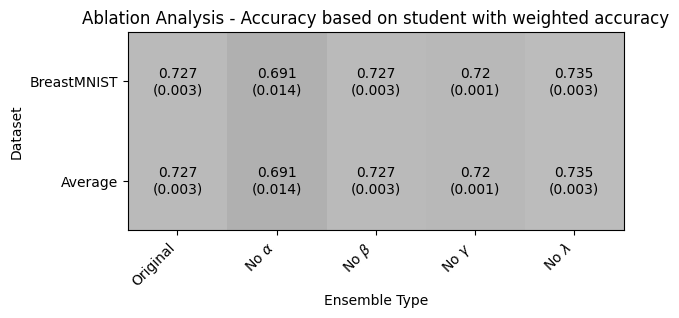

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
df_ordered = df_acuracy
df_std_ordered = df_var
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['BreastMNIST', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['Original', r'No $\alpha$', r'No $\beta$', r'No $\gamma$', r'No $\lambda$']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Analysis - Accuracy based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()


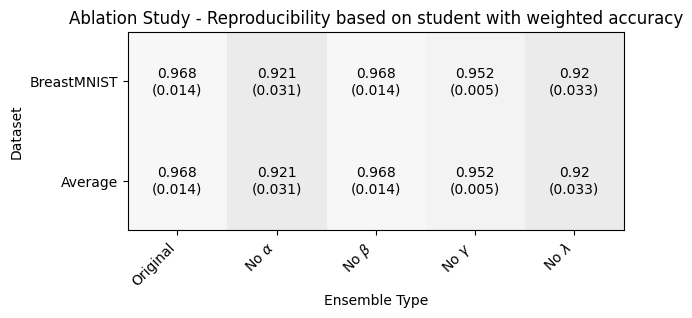

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
df_ordered = df_rep
df_std_ordered = df_var_rep
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['BreastMNIST', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['Original', r'No $\alpha$', r'No $\beta$', r'No $\gamma$', r'No $\lambda$']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Study - Reproducibility based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()